# 이론문제(5점)

문제를 풀고 오답일 경우에는 오답에 대한 근거를 쓰시오.

문제 1. 시계열 데이터 예측은 '내일의 값은 이전의 며칠을 보면 예측할 수 있을 것이다'에서 시작됐다.(O)

문제 2. 시계열 데이터의 hidden layer dimension은 output layer dimension과 같게 하는 것이 모델이 더 쉽게 예측할 수 있는 방법이다. (X)

문제 3. 시계열 데이터를 학습할 때 scaler의 역할과 그에 대한 장점을 서술하시오.

특성들끼리의 단위 차를 없애준다. scaling을 해주기 전에는 단위까지 학습해야 했는데 scaling을 통해 단위 학습을 없애주어 학습의 부담을 덜어줄 수 있다.

문제 4. 아래 코드에 대해 각 줄이 의미하는 바를 적으시오.

    seq_length = 7  # 살펴볼 범위(시퀀스의 길이)
    data_dim = 5    # 특성의 수(학습 데이터 종류)
    hidden_dim = 10 # 히든 레이어 수?
    output_dim = 1  # 출력값의 차원
    learning_rate = 0.01 # 학습률
    iterations = 500     # 반복할 학습 수

    xy = xy[::-1]  # 시간의 역순으로 재배열

    train_size = int(len(xy) * 0.7) # 학습데이터셋 비율
    train_set = xy[0:train_size]    # train_size만큼 학습 데이터 분할
    test_set = xy[train_size - seq_length:] # (1-train_size)만큼 테스트 데이터 분할

문제 5. hihello와 long_sequence의 공통점은 데이터로 주어진 문장 전체를 하나의 샘플로 쓴다는 것이고, 차이점은 hidden layer의 개수가 다르다는 것이다. (X)

# 실습 문제 1(5점)

> **다음은 7일간의 google 주식 데이터의 입력을 받아서 8일차의 종가를 예측하는 코드입니다.
코드를 완성하고 다음의 질문에 답해주세요.**
>

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# scaling function for input data
def minmax_scaler(data):
    numerator   =  data - np.min(data, 0)
    denominator =  np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

# hyper parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net =  Net(data_dim, hidden_dim, output_dim, 1)

# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

**Q1. 각각의 하이퍼 파라미터가 갖는 의미를 설명해주세요. ( ”무엇이 n개라서 n의 파라미터를 갖는다” 를 이해할 수 있도록 간결히 서술해 주세요)**

    seq_length = 7
    # 학습에 활용할 특징수가 7개라서
    data_dim = 5
    # 데이터의 길이, 즉 5일간의 데이터를 이용하겠다
    hidden_dim = 10
    #
    output_dim = 1
    # 마지막 출력값이 1이므로 출력차원 1


 Q2. 위 코드에서 데이터들에 대해 다음과 같은 스케일링을 시행하는 이유를 설명해주세요.

    # scaling data
    train_set = minmax_scaler(train_set)
    test_set = minmax_scaler(test_set)

    각 특성별로 단위가 다르면 학습에 부담을 주기 때문에 스케일링을 해줌으로써 학습 부담을 덜어준다.

# 실습 문제 2(5점)

> 💡 다음의 긴 문장으로부터 sequence dataset을 만들어 봅시다.
**아래의 출력 예시와 같이 출력되도록 코드를 완성해주세요!**
>

In [ ]:
import torch
import numpy as np

sentence = ("Whatever their differences, scientists and artists begin with the same question: can you and I see the same thing"
			" the same way? If so, how? The scientific thinker looks for features of the thing that can be stripped of "
			"subjectivity―ideally, those aspects that can be quantified and whose values will thus never change from one observer"
			" to the next. In this way, he arrives at a realityindependent of all observers. The artist, on the other hand, relies"
			" on the strength of her artistry to effect a marriage between her own subjectivity and that of her readers. "
			"To a scientific thinker, this must sound like magical thinking: you're saying you will imagine something so hard "
			"it'll pop into someone else's head exactly the way you envision it? The artist has sought the opposite of the "
			"scientist's observer-independent reality. She creates a reality dependent upon observers, indeed a reality in which "
			"in order for it to exist at all.")

char_set = list(set(sentence))
char_dic = {c: i for i, c in enumerate(char_set)}
dic_size = len(char_dic)

x_chunck = []
y_chunck = []

seq_len = 15
for i in range(0, len(sentence) - seq_len):
	x_string = sentence[i:i + seq_len]
	y_string = sentence[i + 1: i + seq_len + 1]
	print(i, x_string, '->', y_string)
	x_chunck.append([char_dic[c] for c in x_string])
	y_chunck.append([char_dic[c] for c in y_string])

x_one_hot = [np.eye(dic_size)[x] for x in x_chunck]
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_chunck)

# 실습 문제 3(5점)

> #실습문제 (5점)
**다음 AMZN.csv파일은 주식 dataset 파일입니다.
다음 코드는 주식 dataset을 사용하여 내일의 주식 가격을 예측하는 코드입니다.
빈칸을 완성하고 결과 화면까지 캡쳐해주세요!**
>

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [0.14341958 0.14216362 0.14504411 0.06668882 0.14151059]
 [0.14162337 0.1412566  0.14361903 0.05185859 0.13947141]
 [0.13953476 0.13779342 0.14137346 0.07244756 0.13880556]
 [0.13894994 0.13729869 0.14115754 0.04763294 0.13818132]
 [0.13857401 0.13771096 0.14072571 0.04413821 0.13643347]
 [0.13564995 0.13602061 0.13943018 0.04702144 0.13514338]
 [0.13439679 0.13602061 0.13934383 0.04209087 0.13555954]
 [0.1367778  0.13536096 0.13964611 0.0462963  0.13635024]
 [0.13702843 0.13680395 0.13917109 0.05390112 0.13431106]
 [0.13489805 0.1339592  0.13714144 0.04818378 0.13214706]
 [0.13234994 0.13354692 0.13606184 0.05620558 0.1322719 ]
 [0.13364489 0.13371183 0.13627775 0.04670653 0.13102344]
 [0.13239171 0.13276359 0.13692552 0.03697348 0.13314583]
 [0.13314361 0.134825   0.13783238 0.05441055 0.13331229]
 [0.13443855 0.13635044 0.13904152 0.04682691 0.13701609]
 [0.13819806 0.13647412 0.14115754 0.02953622 0.13680801]] -> [0.13572599]
[[0.14041198 0.1399

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [0.70514654 0.70650519 0.71474739 0.0950289  0.71762832]
 [0.71230413 0.70913305 0.7132828  0.08761631 0.71305234]
 [0.70848871 0.70225055 0.71108592 0.0635729  0.70705857]
 [0.69724515 0.69347164 0.70057995 0.09460989 0.69575549]
 [0.69342967 0.70060449 0.7035189  0.08079119 0.71269056]
 [0.7064602  0.70756402 0.71648539 0.08703315 0.71444082]
 [0.71307693 0.70842074 0.71315587 0.08146075 0.70996259]
 [0.70521416 0.70343452 0.71210135 0.07905036 0.71275902]
 [0.70808298 0.701827   0.71257006 0.06203509 0.7093075 ]
 [0.71388829 0.70792981 0.7194536  0.09237661 0.71799009]
 [0.71230413 0.70743888 0.71865295 0.10350845 0.71819544]
 [0.71545311 0.71347436 0.72310529 0.07017339 0.71982831]
 [0.71940383 0.71935579 0.72754786 0.1866582  0.72871631]
 [0.75267084 0.74604855 0.73947939 0.2743609  0.73517939]
 [0.73235708 0.75067863 0.74286744 0.1936129  0.75790288]
 [0.7505651  0.74653943 0.7561561  0.12373325 0.75664157]] -> [0.75086295]
[[0.65882966 0.6519

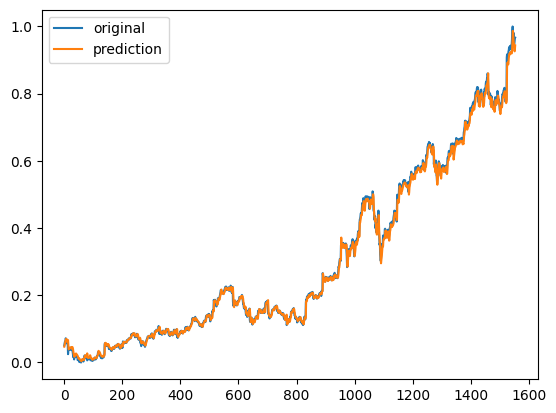

In [6]:
import pandas as pd
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

#데이터 전처리
df=pd.read_csv('./AMZN.csv')

df.head()
df['Y'] = df['Close']
df = df.drop(['Date', 'Close', 'Adj Close'], axis = 1)
data = df.values
print(data)

#hyper parameters
seq_length = 28
data_dim = 5
hidden_dim = 20
output_dim = 1
learning_rate = 0.01
iterations = 700

#scaling function for input data
def MinMaxScalar(data):
  numerator=data-np.min(data,0)
  denominator=np.max(data,0) - np.min(data,0)
  return numerator/(denominator + 1e-7)

#make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

train_size = int(len(data) * 0.7)
train_set = data[0: train_size]
test_set = data[train_size - seq_length : ]

#scaling data 총 1.5점
train_set = MinMaxScalar(train_set)
test_set = MinMaxScalar(test_set)

#make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

#convert to tensor
trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)

testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)

class Net(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn=torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc=torch.nn.Linear(hidden_dim,output_dim,bias=True)

    def forward(self, x):
          x, _status=self.rnn(x)
          x=self.fc(x[:,-1])
          return x

# 총 1.5점
net= Net(data_dim, hidden_dim, output_dim, 1)

criterion= torch.nn.MSELoss()
optimizer= optim.Adam(net.parameters(), lr=learning_rate)

#start training 총 2점
for i in range(iterations):
    optimizer.zero_grad()
    outputs = net(trainX_tensor)

    loss = criterion(outputs, trainY_tensor)
    loss.backward()

    optimizer.step()

    print(i, loss.item())

plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original','prediction'])
plt.show()

# 실습 문제 4(5점)

> 다음은 문장을 예측하는 베이스 코드이며, 최적화 알고리즘으로 Adam이 사용되었습니다. 최적화 알고리즘으로 Adam, RMSprop, 모멘텀, Adagrad 4가지를 각각 적용해보고 가장 결과 성능이 좋은 최적화 알고리즘을 사용했을 때의 코드를 작성한 다음, 결과 화면을 캡쳐 해서 올리시오. (필요 시 training 반복 횟수를 조정해도 됩니다. 단, 과적합 방지를 위해 훈련 반복 횟수는 최대 400까지만 가능합니다.)
>

In [47]:
import torch
import torch.optim as optim
import numpy as np

torch.manual_seed(0)

sentence = ("The entrance to a honeybee colony is a market place for information about the state"
            "of the colony and the environment outside the hive. Studying interactions on the"
            "dancefloor provides us with a number of illustrative examples of how individuals"
            "changing their own behavior in response to local information. For example, upon "
            "returning to their hive honeybees that have collected water search out a receiver"
            "bee to unload their water to within the hiv")

# make dictionary
char_set = list(set(sentence))
char_dic = {c: i for i, c in enumerate(char_set)}

# hyper parameters
dic_size = len(char_dic)
hidden_size = len(char_dic)
sequence_length = 10  # Any arbitrary number
learning_rate = 0.1

# data setting
x_data = []
y_data = []

for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    # print(i, x_str, '->', y_str)

    x_data.append([char_dic[c] for c in x_str])  # x str to index
    y_data.append([char_dic[c] for c in y_str])  # y str to index

x_one_hot = [np.eye(dic_size)[x] for x in x_data]

# transform as torch tensor variable
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

# declare RNN + FC
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

# declare RNN + FC
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x


net = Net(dic_size, hidden_size, 2)


  # loss & optimizer setting
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)
#optimizer = optim.Adagrad(net.parameters(), learning_rate)
#optimizer = optim.RMSprop(net.parameters(), learning_rate)
#optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.95)

loss_list = []

# start training
for i in range(250):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()

    results = outputs.argmax(dim=2)
    predict_str = ""
    for j, result in enumerate(results):
        # print(i, j, ''.join([char_set[t] for t in result]), loss.item())
        if j == 0:
            predict_str += ''.join([char_set[t] for t in result])
        else:
            predict_str += char_set[result[-1]]

    print(predict_str)

  dh h    h  d  d dw h    dd    vh h d    d          x     d  d  dhdd        hh    dhdd  h     vhd  hd  h hd  hddd d d     hdd  hd     d     d h  h  d   dhddc dd    d     h    dd  hd    d d dd       dd          d  hdhd     h d  dc      d  h         x hd    hd  d   d  d d  hd h  hh     h        c  d  dhd  w hdd     d    hd     x d hd  d    hd   ddc h    h      dd  d         hd    hd      d   dh     d     dd  d   d hd    hd    hd  d d   hd  hd 
eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
    o   o n n    n n nn  on         n n n n  o n nn   n      n o n o n o     no n n    n o n  n n  n o n  

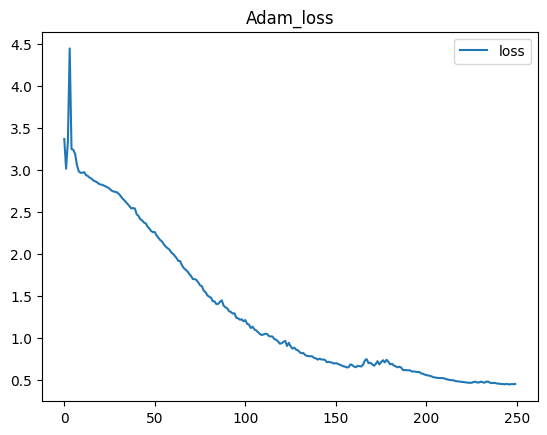

0.4550451636314392


In [48]:
plt.plot(loss_list)
plt.legend(['loss'])
plt.title('Adam_loss')
plt.show()
print(loss_list[-1])

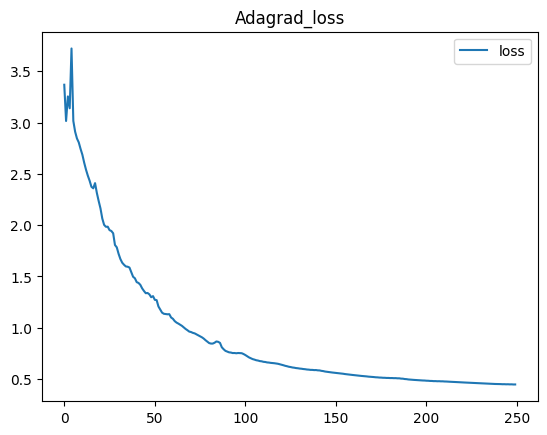

0.4472914934158325


In [46]:
plt.plot(loss_list)
plt.legend(['loss'])
plt.title('Adagrad_loss')
plt.show()
print(loss_list[-1])

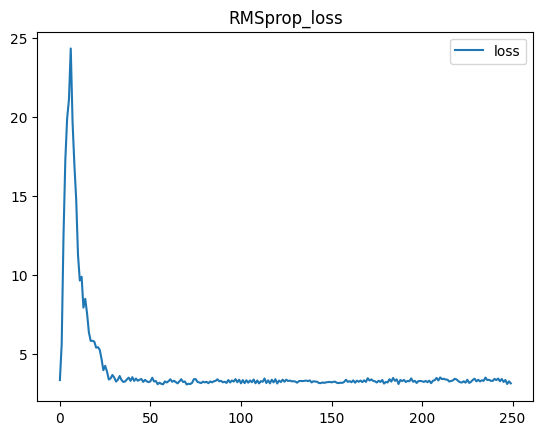

In [36]:
plt.plot(loss_list)
plt.legend(['loss'])
plt.title('RMSprop_loss')
plt.show()

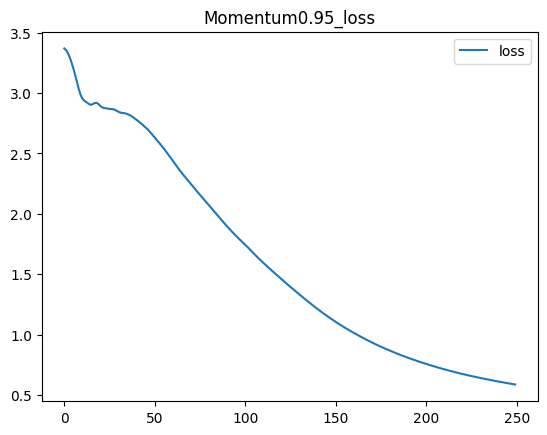

In [44]:
plt.plot(loss_list)
plt.legend(['loss'])
plt.title('Momentum0.95_loss')
plt.show()